In [38]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import handy
import glob
from joblib import Parallel, delayed
import sigpy as sp
import sigpy.plot as pl
import sigpy.mri as mr
from scipy.io import loadmat
from scipy.io import savemat
import sys
import math
from scipy import signal
from itertools import product
import time

In [33]:
path_caipi_data = 'C:/Users/jamalzada/Documents/Data/200403_caipi_pilot/'

In [34]:
datalist = sorted(glob.glob(path_caipi_data+"raw*.mat"))
datalist

['C:/Users/jamalzada/Documents/Data/200403_caipi_pilot\\raw_001_full.mat',
 'C:/Users/jamalzada/Documents/Data/200403_caipi_pilot\\raw_002_sense2x2.mat',
 'C:/Users/jamalzada/Documents/Data/200403_caipi_pilot\\raw_003_sense2x3.mat',
 'C:/Users/jamalzada/Documents/Data/200403_caipi_pilot\\raw_004_caipi2x2.mat',
 'C:/Users/jamalzada/Documents/Data/200403_caipi_pilot\\raw_005_caipi2x3.mat',
 'C:/Users/jamalzada/Documents/Data/200403_caipi_pilot\\raw_006_caipi2x2_fullcenter.mat',
 'C:/Users/jamalzada/Documents/Data/200403_caipi_pilot\\raw_007_caipi2x3_fullcenter.mat']

In [27]:
data_help = Parallel(n_jobs=-1,backend='loky')(delayed(handy.read_matlab)(datalist[i]) for i in range(len(datalist)))

In [36]:
data_complex = [data_help[i]['alldata']['real']+1j*data_help[i]['alldata']['imag'] for i in range(len(datalist))]

In [9]:
ksp = np.load('cartesian_ksp.npy')
ksp.shape

(8, 230, 180)

In [10]:
data_complex[6].shape

(32, 116, 108, 108)

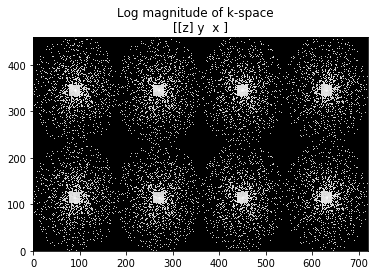

In [11]:
pl.ImagePlot(ksp, mode='l',z=0, title='Log magnitude of k-space')

In [12]:
def take_center(array,size):
    """Takes the center data of an array

    Parameters:
        array (numpy array): array of data
        size (int): percentage of the array

    Returns (numpy array): center of array 
    """
    size /= 200
    Nc,Nx,Ny,Nz = array.shape
    nx,ny,nz = int(Nx/2), int(Ny/2),int(Nz/2)
    rx,ry,rz = math.ceil(Nx*size), math.ceil(Ny*size), math.ceil(Nz*size)
    reduced = array[:,nx-rx:nx+rx,ny-ry:ny+ry,nz-rz:nz+rz]
    print(nx,ny,nz,rx,ry,rz)
    return reduced

In [37]:
datalist

['C:/Users/jamalzada/Documents/Data/200403_caipi_pilot\\raw_001_full.mat',
 'C:/Users/jamalzada/Documents/Data/200403_caipi_pilot\\raw_002_sense2x2.mat',
 'C:/Users/jamalzada/Documents/Data/200403_caipi_pilot\\raw_003_sense2x3.mat',
 'C:/Users/jamalzada/Documents/Data/200403_caipi_pilot\\raw_004_caipi2x2.mat',
 'C:/Users/jamalzada/Documents/Data/200403_caipi_pilot\\raw_005_caipi2x3.mat',
 'C:/Users/jamalzada/Documents/Data/200403_caipi_pilot\\raw_006_caipi2x2_fullcenter.mat',
 'C:/Users/jamalzada/Documents/Data/200403_caipi_pilot\\raw_007_caipi2x3_fullcenter.mat']

In [8]:
path = 'raw_data.mat'
data = handy.read_matlab(path)
ksp = data['raw'].squeeze()
sdata = loadmat('sref.mat')
g=sdata['s_ref']
raw = ksp['real']+1j*ksp['imag']
sref=np.copy(g)

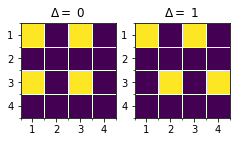

In [9]:
R=4
p=handy.caipi(R,2,[0,1])
handy.plot_caipi(p,[0,1])
h = int(96/R)
mask = np.kron(np.ones((h,h)),p[0])
#mask=1

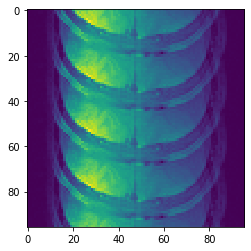

In [10]:
px = handy.caipi(4,1,[0])
plt.imshow(abs(sp.ifft(np.kron(np.ones((h,h)),px[0].T)*raw[0])))

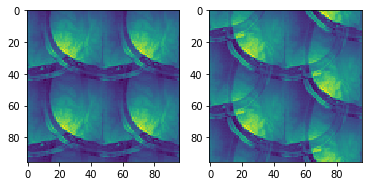

In [11]:
plt.subplot(1,2,1)
plt.imshow(abs(sp.ifft(np.kron(np.ones((h,h)),p[0])*raw[0])))
plt.subplot(1,2,2)
plt.imshow(abs(sp.ifft(np.kron(np.ones((h,h)),p[1])*raw[0])))

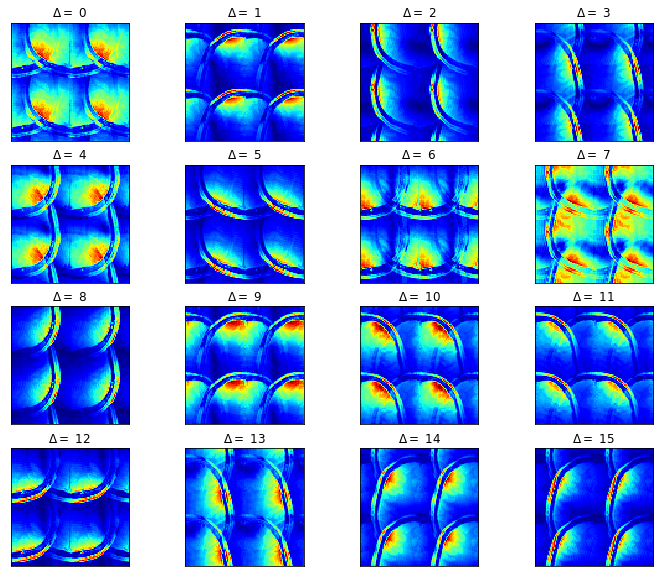

In [12]:
img = sp.ifft(mask*raw,axes=(1,2))
img_r2 = handy.swap(img)[:,:,None,:]
handy.plot_patterns(abs(img),4,'jet')

In [13]:
def sense(img,csm,R):
    [Nx,Ny,Nz,Nc] = img.shape
    out = np.zeros((Nx,Ny),dtype=complex)
    h = int(Nx/R)
    #print(h)
    for x in np.arange(h):
        x_idx = np.arange(x,Nx,h)
        
        for y in np.arange(Ny):
            S = csm[x_idx,y,0,:].T
            #S = np.reshape(csm[x_idx,y,0,:],(R,-1)).T
            hulp = np.reshape(img[x,y,0,:],(-1,1))
            out[x_idx,y] = (np.linalg.pinv(S)@hulp).squeeze()
        #print(S.shape,hulp.shape)
            #print(x_idx,y)
            
    return out

In [14]:
def sense3(img,csm,rx,ry):
    R = rx*ry
    [Nx,Ny,Nz,Nc] = img.shape
    out = np.zeros((Nx,Ny),dtype=complex)
    hx = int(Nx/rx)
    hy = int(Ny/ry)
    g = []
    for x in np.arange(hx): # loop along x-coordinates
        x_idx = np.arange(x,Nx,hx)
        for y in np.arange(hy): # loop along y-coordinates
            y_idx = np.arange(y,Ny,hy)[:]
            coord = np.array(list(product(x_idx,y_idx)))
            x_alias = csm[coord[:,0],coord[:,1],0,:]
            S = np.reshape(x_alias,(R,-1)).T
            hulp = np.reshape(img[x,y,0,:],(-1,1))
            vhelp = (np.linalg.pinv(S)@hulp).squeeze()
            #m = np.reshape(vhelp,(rx,ry))
            #print("this is m\n", m)
            out[coord[:,0],coord[:,1]] = vhelp
            #print(out[x_idx,:][:,y_idx])
            #print(x_idx,y,'and',x,y_idx)
    return out

In [15]:
brain = np.repeat(img_r2,96,axis=2)
sref_repeat = np.repeat(sref,96,axis=2)

In [16]:
def sense3numpy(img,csm,rx,ry):
    rx,ry = 2,2
    R = rx*rx
    Nx,Ny,Nz,Nc = 96,96,96,16
    out = np.zeros((Nx,Ny,Nz),dtype=complex)
    hx = int(Nx/rx)
    hy = int(Ny/ry)
    coord_matrix = np.zeros((hx,hy,R,2),dtype=int)
    csm_matrix = np.zeros((hx,hy,R,Nz,Nc),dtype=complex)
    S_matrix = np.zeros((hx,hy,Nz,Nc,R),dtype=complex)
    hulp_matrix = np.zeros((hx,hy,Nz,Nc),dtype=complex)
    for x in np.arange(hx):
        x_idx = np.arange(x,Nx,hx)
        for y in np.arange(hy):
            y_idx = np.arange(y,Ny,hy)
            coord_matrix[x,y] = np.array(list(product(x_idx,y_idx)))
            csm_aliased_points = csm[coord_matrix[x,y,:,0],coord_matrix[x,y,:,1],:,:]
            csm_matrix[x,y] = np.copy(csm_aliased_points)
            for z in np.arange(Nz):
                S = np.reshape(csm_matrix[x,y,:,z,:],(R,-1)).T
                hulp = np.reshape(img[x,y,z,:],(-1,1)).squeeze()
                S_matrix[x,y,z] = np.copy(S)
                hulp_matrix[x,y,z] = np.copy(hulp)
    S_all = np.reshape(S_matrix,(hx*hy*Nz,Nc,R))
    S_inv = np.linalg.pinv(S_all)
    hulp_all = np.reshape(hulp_matrix,(hx*hy*Nz,Nc))
    unfold = np.einsum('ijk,ik->ij',S_inv,hulp_all)
    unfold_reshape = np.reshape(unfold,(hx,hy,Nz,R))
    for i in range(hx):
        for j in range(hy):
            for z in range(Nz):
                out[coord_matrix[i,j,:,0],coord_matrix[i,j,:,1],z] = unfold_reshape[i,j,z].squeeze()
    return out

In [17]:
out_brain = sense3numpy(brain,sref_repeat,2,2)

In [18]:
def sense2numpy(img,csm,rx,ry):
    rx,ry = 2,2
    R = rx*ry
    Nx,Ny,Nz,Nc = img.shape
    out = np.zeros((Nx,Ny),dtype=complex)
    hx = int(Nx/rx)
    hy = int(Ny/ry)
    coord_matrix = np.zeros((hx,hy,R,2),dtype=int)
    csm_matrix = np.zeros((hx,hy,R,Nc),dtype=complex)
    S_matrix = np.zeros((hx,hy,Nc,R),dtype=complex)
    hulp_matrix = np.zeros((hx,hy,Nc),dtype=complex)
    for x in np.arange(hx):
        x_idx = np.arange(x,Nx,hx)
        for y in np.arange(hy):
            y_idx = np.arange(y,Ny,hy)
            coord_matrix[x,y] = np.array(list(product(x_idx,y_idx)))
            csm_aliased_points = csm[coord_matrix[x,y,:,0],coord_matrix[x,y,:,1],0,:]
            csm_matrix[x,y] = np.copy(csm_aliased_points)
            S = np.reshape(csm_matrix[x,y,:,:],(R,-1)).T
            hulp = np.reshape(img[x,y,:],(-1,1)).squeeze()
            S_matrix[x,y] = np.copy(S)
            hulp_matrix[x,y] = np.copy(hulp)
    S_all = np.reshape(S_matrix,(hx*hy,Nc,R))
    S_inv = np.linalg.pinv(S_all)
    hulp_all = np.reshape(hulp_matrix,(hx*hy,Nc))
    unfold = np.einsum('ijk,ik->ij',S_inv,hulp_all)
    unfold_reshape = np.reshape(unfold,(hx,hy,Nz,R))
    for i in range(hx):
        for j in range(hy):
            out[coord_matrix[i,j,:,0],coord_matrix[i,j,:,1]] = unfold_reshape[i,j,:].squeeze()
    return out

In [19]:
img = sense2numpy(img_r2,sref,2,2)

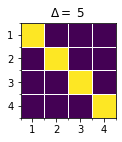

In [20]:
shifts = [0,1,2,3,4,5,6,7,8]
shifts = [5]
R=4
rx = 2
p=handy.caipi(R,1,shifts)
handy.plot_caipi(p,shifts)
h = int(96/R)
mask = np.kron(np.ones((h,h)),p[0])
#mask=1

IndexError: index 1 is out of bounds for axis 0 with size 1

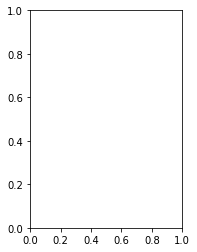

In [21]:
plt.subplot(1,2,1)
plt.imshow(p[1])
plt.subplot(1,2,2)
psf = abs((np.fft.fftn(p[1])))
plt.imshow(psf)
np.argwhere(np.around(psf,2)!=0)
img = sp.ifft(mask*raw,axes=(1,2))
img_r2 = handy.swap(img)[:,:,None,:]

In [ ]:
img_r2_repeat = np.repeat(img_r2,96,axis=2)
img_r2_repeat.shape

In [304]:
def caipi_recon3d(img,csm,rx,ry,shifts):
    R = rx*ry
    p = handy.caipi(R,rx,shifts)
    binary_aliasing_cell = abs(np.fft.fftn(p[0]))
    spatial_coord = np.argwhere(np.around(binary_aliasing_cell,2)!=0)
    Nx,Ny,Nz,Nc = img.shape
    out = np.zeros((Nx,Ny,Nz),dtype=complex)
    ry = R//rx
    hx = int(Nx/rx)
    hy = int(Ny/ry)
    coord_matrix_check = np.zeros((Nx,Ny),dtype=int)
    coord_matrix = np.zeros((int(hx*hy/Nx),Ny,R,2),dtype=int)
    coord_test = np.zeros((int(hx*hy/Nx),Ny),dtype=int)
    csm_matrix = np.zeros((int(hx*hy/Nx),Ny,R,Nz,Nc),dtype=complex)
    S_matrix = np.zeros((int(hx*hy/Nx),Ny,Nz,Nc,R),dtype=complex)
    hulp_matrix = np.zeros((int(hx*hy/Nx),Ny,Nz,Nc),dtype=complex)
    pixel_count = 0
    FOVx_scaled = Nx/R
    FOVy_scaled = Ny/R
    count = 0
    i = 0
    for x in np.arange(Nx):
        for y in np.arange(Ny):
            if coord_matrix_check[x,y]==0:
                coord_matrix[x,y,:,:] = ([x,y] + [FOVx_scaled,FOVy_scaled]*spatial_coord)%96
                coord_matrix_check[coord_matrix[x,y,:,0],coord_matrix[x,y,:,1]] = 1
                coord_test[x,y] = 1
                csm_aliased_points = csm[coord_matrix[x,y,:,0],coord_matrix[x,y,:,1],:,:]
                csm_matrix[x,y] = np.copy(csm_aliased_points)
                for z in np.arange(Nz):
                    S = np.reshape(csm_matrix[x,y,:,z,:],(R,-1)).T
                    hulp = np.reshape(img[x,y,z,:],(-1,1)).squeeze()
                    S_matrix[x,y,z] = np.copy(S)
                    hulp_matrix[x,y,z] = np.copy(hulp)
            if coord_matrix_check.all():
                print('break at {},{}'.format(x,y))
                break   
        else:
            continue
        break
    S_all = np.reshape(S_matrix,(hx*hy*Nz,Nc,R))
    S_inv = np.linalg.pinv(S_all)
    hulp_all = np.reshape(hulp_matrix,(hx*hy*Nz,Nc))
    unfold = np.einsum('ijk,ik->ij',S_inv,hulp_all)
    unfold_reshape = np.reshape(unfold,(int(hx*hy/Nx),Ny,Nz,R))
    #out[coord_matrix[:,:,:,0],coord_matrix[:,:,]]
    for i in range(coord_test.shape[0]):
        for j in range(coord_test.shape[1]):
            for z in range(Nz):
                out[coord_matrix[i,j,:,0],coord_matrix[i,j,:,1],z] = unfold_reshape[i,j,z].squeeze()
    return out

In [305]:
out3d = caipi_recon3d(img_r2_repeat,sref_repeat,2,2,[1])

break at 23,95


In [343]:
def caipi_recon(img,csm,rx,ry,shifts):
    R = rx*ry
    Nx,Ny,Nz,Nc = img.shape
    out = np.zeros((Nx,Ny),dtype=complex)
    p = handy.caipi(R,rx,shifts)
    binary_aliasing_cell = abs(np.fft.fftn(p[0]))
    spatial_coord = np.argwhere(np.around(binary_aliasing_cell,2)!=0)
    ry = R//rx
    hx = int(Nx/rx)
    hy = int(Ny/ry)
    coord_matrix_check = np.zeros((Nx,Ny),dtype=int)
    coord_matrix = np.zeros((int(hx*hy/Nx),Ny,R,2),dtype=int)
    coord_test = np.zeros((int(hx*hy/Nx),Ny),dtype=int)
    csm_matrix = np.zeros((int(hx*hy/Nx),Ny,R,Nc),dtype=complex)
    S_matrix = np.zeros((int(hx*hy/Nx),Ny,Nc,R),dtype=complex)
    hulp_matrix = np.zeros((int(hx*hy/Nx),Ny,Nc),dtype=complex)
    out = np.zeros((Nx,Ny),dtype=complex)
    pixel_count = 0
    FOVx_scaled = Nx/R
    FOVy_scaled = Ny/R
    count = 0
    i = 0
    time.time()
    for x in np.arange(Nx):
        for y in np.arange(Ny):
            if coord_matrix_check[x,y]==0:
                coord_matrix[x,y,:,:] = ([x,y] + [FOVx_scaled,FOVy_scaled]*spatial_coord)%96
                coord_matrix_check[coord_matrix[x,y,:,0],coord_matrix[x,y,:,1]] = 1
                coord_test[x,y] = 1
                csm_aliased_points = csm[coord_matrix[x,y,:,0],coord_matrix[x,y,:,1],0,:]
                csm_matrix[x,y] = np.copy(csm_aliased_points)
                S = np.reshape(csm_matrix[x,y,:,:],(R,-1)).T
                hulp = np.reshape(img[x,y,:],(-1,1)).squeeze()
                S_matrix[x,y] = np.copy(S)
                hulp_matrix[x,y] = np.copy(hulp)
            if coord_matrix_check.all():
                print('break at {},{}'.format(x,y))
                break   
        else:
            continue
        break
    S_all = np.reshape(S_matrix,(hx*hy,Nc,R))
    S_inv = np.linalg.pinv(S_all)
    hulp_all = np.reshape(hulp_matrix,(hx*hy,Nc))
    unfold = np.einsum('ijk,ik->ij',S_inv,hulp_all)
    unfold_reshape = np.reshape(unfold,(int(hx*hy/Nx),Ny,1,R))
    #out[coord_matrix[:,:,:,0],coord_matrix[:,:,:,1]] = unfold_reshape[:,:,:]
    for i in range(coord_test.shape[0]):
        for j in range(coord_test.shape[1]):
            out[coord_matrix[i,j,:,0],coord_matrix[i,j,:,1]] = unfold_reshape[i,j,:].squeeze()
    return out

[[[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]]]


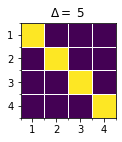

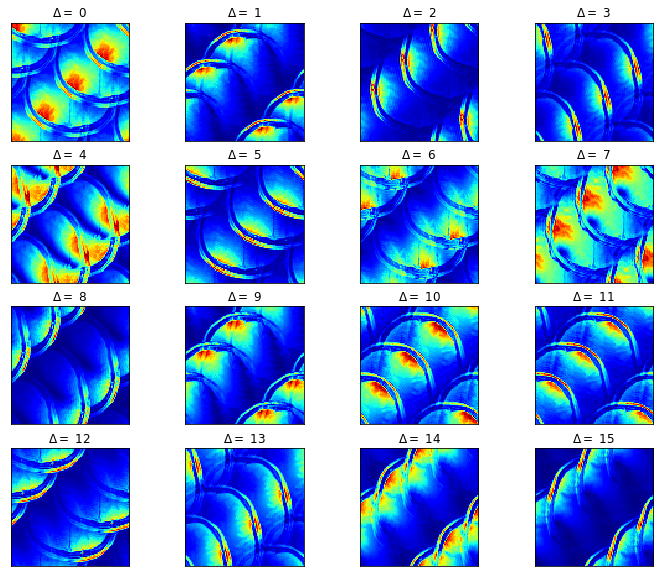

In [346]:
rx,ry = 1,4
R=rx*ry
shifts = [5]
p=handy.caipi(R,rx,shifts)
print(p)
handy.plot_caipi(p,shifts)
h = int(96/R)
mask = np.kron(np.ones((h,h)),p[0])
img = sp.ifft(mask*raw,axes=(1,2))
img_r2 = handy.swap(img)[:,:,None,:]
handy.plot_patterns(abs(img),4,'jet')

break at 23,95


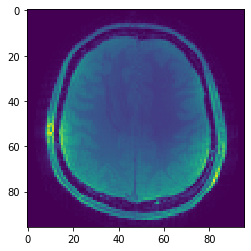

In [347]:
out = caipi_recon(img_r2,sref,rx,ry,shifts).squeeze()
plt.imshow(abs(out))